Nama : Valentino manurung

NIM : 210402060

## Pendeteksi Ekspresi Wajah Menggunakan CNN


Sistem ini dirancang untuk dapat mendeteksi emosi manusia secara real-time melalui webcam. Dimulai dengan memproses dataset gambar wajah yang dikategorikan berdasarkan emosi tertentu, model CNN dibangun dan dilatih untuk mengklasifikasikan emosi seperti marah, jijik, takut, senang, netral, sedih, dan terkejut. Setelah model dilatih dan disimpan, aplikasi dapat mendeteksi wajah dalam video secara langsung, memprediksi emosi yang muncul pada wajah yang terdeteksi, dan menampilkan hasil prediksi tersebut di layar. Dengan demikian, sistem ini memungkinkan interaksi manusia dengan komputer melalui pengenalan ekspresi wajah secara otomatis.

file lengkap dapat dilihat di: https://github.com/Valentino-SSR/Emotion-CNN

mengimport library yang akan digunakan


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from zipfile import ZipFile

# L
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


Dataset yang akan digunakan diambil dari kaggle dan dapat diakses melalui link berikut: https://www.kaggle.com/datasets/msambare/fer2013

dalam proses pembangunakan model menggunakan google collab data yang dimasukkan berupa zip sehingga perlu diekstrak terlebih dahulu.
Dataset sendiri berisi gambar gambar berupa ekspresi seperti angry (marah), disgust(jijik), happy (senang), neutral(netral), surprise(terkejut), fear (takut), dan sad(sedih)


In [3]:
with ZipFile("archive (8).zip", 'r') as docfile:
    docfile.extractall()

kode dibawah ini digunakan untuk menampilkan 9 gambar dari folder tertentu dalam grid 3x3 menggunakan matplotlib. Ukuran gambar ditentukan oleh parameter psize, yang dalam hal ini diset ke 48x48 piksel. Gambar-gambar yang akan divisualisasikan diambil dari folder "train/neutral", di mana folder ini mewakili kategori atau label gambar yang telah ditentukan dalam variabel eks. Dengan memanfaatkan fungsi plt.figure(figsize=(12,12)), dibuat kanvas berukuran 12x12 inci untuk menampilkan gambar. Dalam perulangan, setiap gambar dimuat menggunakan fungsi load_img dari modul Keras, yang juga mengatur ukuran gambar menjadi sesuai dengan target_size. Nama file gambar diperoleh dari daftar file dalam folder menggunakan os.listdir, dengan indeks perulangan digunakan untuk mengakses setiap file. Gambar-gambar tersebut kemudian ditampilkan dalam grid dengan bantuan fungsi plt.subplot untuk membuat layout grid dan plt.imshow untuk memvisualisasikan gambar. Setelah semua subplot selesai diatur, plt.show() digunakan untuk menampilkan hasil visualisasi,

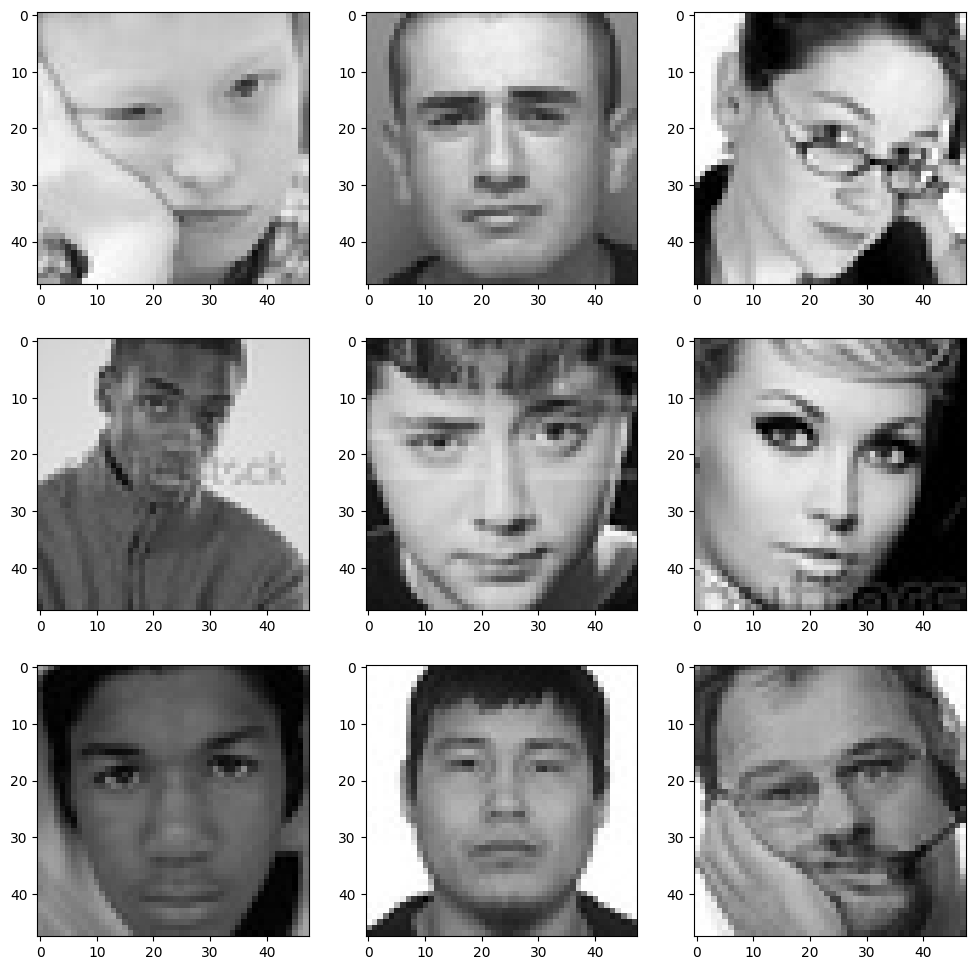

In [4]:
psize = 48
eks = 'neutral'
plt.figure(figsize=(12,12))
for i in range (1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img("train/"+eks+"/"+
                  os.listdir("train/"+eks)[i], target_size= (psize, psize))
    plt.imshow(img)
plt.show()

Dataset gambar diproses dengan menggunakan dua instance ImageDataGenerator: datagen_train untuk data pelatihan dan datagen_val untuk data pengujian. Keduanya dibuat tanpa augmentasi gambar tambahan, karena tidak ada parameter augmentasi yang diberikan. Dataset pelatihan diambil dari folder "train", sedangkan dataset pengujian diambil dari folder "test". Gambar pada kedua dataset diubah ukurannya menjadi 48x48 piksel (sesuai dengan nilai psize) dan dikonversi ke skala abu-abu menggunakan parameter color_mode="grayscale". Dataset pelatihan diproses dengan opsi shuffle=True untuk mengacak urutan gambar, yang membantu meningkatkan generalisasi model, sementara dataset pengujian menggunakan shuffle=False untuk mempertahankan urutan asli, memungkinkan evaluasi yang konsisten. Kedua dataset diatur untuk memiliki batch size 128, sehingga gambar akan diproses dalam kelompok-kelompok sebesar 128 selama pelatihan atau evaluasi. Dengan class_mode="categorical", label gambar dianggap berupa kategori yang di-encode secara one-hot, menjadikannya cocok untuk masalah klasifikasi multi-kelas. Kode ini memanfaatkan struktur folder untuk membagi dataset berdasarkan kelas, di mana setiap subfolder di dalam folder utama (train atau test) dianggap sebagai satu kelas.

In [14]:
batch_size=128
datagen_train=ImageDataGenerator()
datagen_val=ImageDataGenerator()

train_set= datagen_train.flow_from_directory("train",
                                            target_size=(psize,psize),
                                            color_mode="grayscale",
                                             batch_size=batch_size,
                                            class_mode="categorical",
                                            shuffle=True)
test_set=datagen_val.flow_from_directory("test",
                                       target_size=(psize,psize),
                                       color_mode="grayscale",
                                       batch_size=batch_size,
                                       class_mode="categorical",
                                       shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model CNN dibangun menggunakan arsitektur berlapis dengan Sequential API. Layer pertama adalah lapisan konvolusi dengan 64 filter berukuran 3x3, diikuti oleh normalisasi batch, fungsi aktivasi ReLU, pooling maksimal 2x2, dan dropout sebesar 25%. Lapisan ini dirancang untuk mendeteksi fitur dasar gambar. Lapisan kedua memiliki 128 filter 5x5 dengan proses serupa, tetapi menggunakan filter yang lebih besar untuk menangkap pola yang lebih kompleks. Lapisan ketiga dan keempat masing-masing memiliki 512 filter 3x3, dengan konfigurasi identik, meningkatkan kemampuan model untuk memahami fitur tingkat tinggi. Setelah lapisan konvolusi, data diflatkan menggunakan layer Flatten, yang mengubah keluaran dari bentuk matriks menjadi vektor.

Model kemudian dilengkapi dengan dua fully connected (FC) layer, masing-masing dengan 256 dan 512 neuron, yang bertujuan mengintegrasikan fitur-fitur yang diekstraksi oleh lapisan konvolusi. Setiap FC layer diikuti oleh normalisasi batch, fungsi aktivasi ReLU, dan dropout sebesar 25% untuk mengurangi overfitting. Layer output menggunakan 7 neuron (sesuai dengan jumlah kelas) dan fungsi aktivasi softmax untuk menghasilkan probabilitas untuk setiap kelas. Model dikompilasi dengan optimizer Adam menggunakan laju pembelajaran 0.0001, fungsi loss categorical_crossentropy untuk menangani klasifikasi multi-kelas, dan metrik evaluasi akurasi. Akhirnya, model.summary() menampilkan ringkasan arsitektur model, termasuk jumlah parameter pada setiap lapisan. Model ini dirancang untuk menangani tugas klasifikasi gambar secara efisien dengan fokus pada generalisasi dan pengurangan overfitting.

In [16]:
no_of_classes=7

model=Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


#2nd CNN layer
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes,activation="softmax"))

opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

ModelCheckpoint menyimpan bobot model terbaik selama pelatihan berdasarkan metrik val_acc (akurasi validasi). Hanya model dengan performa terbaik yang akan disimpan di file "./model.keras". EarlyStopping menghentikan pelatihan lebih awal jika tidak ada peningkatan performa berdasarkan val_loss (kerugian validasi) setelah 3 epoch, untuk menghindari overfitting dan pemborosan sumber daya komputasi. Selain itu, opsi restore_best_weights=True memastikan model kembali ke bobot terbaiknya. ReduceLROnPlateau secara dinamis mengurangi laju pembelajaran (learning rate) jika val_loss tidak membaik dalam 3 epoch berturut-turut. Faktor pengurangannya adalah 0.2, membantu model untuk mengeksplorasi parameter lebih halus di fase akhir pelatihan. Semua callback ini disatukan dalam daftar callbacks_list.

Model dikompilasi kembali untuk memastikan konfigurasi terbaru, menggunakan fungsi kerugian categorical_crossentropy, optimizer Adam dengan laju pembelajaran awal 0.001, dan metrik akurasi. Akhirnya, pelatihan model akan dijalankan dengan callback ini selama 48 epoch, memungkinkan pemantauan performa, optimalisasi otomatis, dan penyimpanan model terbaik. Kombinasi callback ini bertujuan untuk meningkatkan efisiensi pelatihan sekaligus menghindari overfitting.

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

proses pelatihan model CNN dilakukan dengan menggunakan dataset pelatihan dan validasi yang telah disiapkan sebelumnya. Fungsi model.fit digunakan untuk melatih model dengan data yang diberikan selama 48 epoch. Dataset pelatihan (train_set) diolah dalam batch sesuai ukuran yang telah ditentukan (batch_size), dan jumlah langkah per epoch dihitung dengan membagi total sampel pelatihan dengan ukuran batch (steps_per_epoch). Setelah setiap epoch, model dievaluasi menggunakan dataset validasi (validation_data) untuk memantau performa dengan menghitung nilai loss dan akurasi. Jumlah langkah validasi per epoch (validation_steps) juga ditentukan dengan membagi total sampel validasi dengan ukuran batch. Selama pelatihan, metrik seperti loss dan akurasi pada data pelatihan dan validasi disimpan dalam variabel history, yang memungkinkan pengguna untuk menganalisis performa model, memantau konvergensi, dan mendeteksi overfitting melalui grafik.








In [19]:
history = model.fit( train_set,
                                steps_per_epoch = train_set.n // train_set.batch_size,
                                epochs = epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n // test_set.batch_size)

Epoch 1/48


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


224/224 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step - accuracy: 0.2694 - loss: 1.9259 - val_accuracy: 0.3605 - val_loss: 1.6739
Epoch 2/48
  1/224 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3828 - loss: 1.4841

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3828 - loss: 1.4841 - val_accuracy: 0.3000 - val_loss: 1.7671
Epoch 3/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4402 - loss: 1.4676 - val_accuracy: 0.4000 - val_loss: 1.6808
Epoch 4/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4766 - loss: 1.4561 - val_accuracy: 0.5000 - val_loss: 1.8627
Epoch 5/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.5120 - loss: 1.2767 - val_accuracy: 0.5042 - val_loss: 1.3111
Epoch 6/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4922 - loss: 1.2703 - val_accuracy: 0.6000 - val_loss: 1.2920
Epoch 7/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5452 - loss: 1.1842 - val_accuracy: 0.4907 - val_loss: 1.3023
Epoch 8/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 0.5469 - loss: 1.1306 - val_accuracy: 1.0000 - val_loss: 0.1848
Epoch 9/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.5751 - loss: 1.1140 - val_accuracy: 0.55

Fungsi model.evaluate digunakan untuk mengukur performa model pada dataset pengujian dengan menghitung nilai loss dan akurasi. Dataset pengujian disusun dalam batch, dan jumlah langkah evaluasi ditentukan dengan membagi total sampel pengujian (test_set.n) dengan ukuran batch (test_set.batch_size). Setelah evaluasi selesai, fungsi mengembalikan dua nilai utama: loss (kerugian) dan accuracy (akurasi) dari model pada data pengujian. Nilai akurasi dikalikan 100 untuk ditampilkan dalam format persentase. Proses ini membantu mengevaluasi seberapa baik model generalisasi terhadap data baru yang belum pernah dilihat selama pelatihan, memberikan indikasi performa model dalam situasi nyata. Hasil akurasi ditampilkan dalam format yang mudah dibaca untuk analisis lebih lanjut.

dapat dilihat model memiliki akurasi sekitar 65%

In [ ]:
# Evaluasi model menggunakan test_set
loss, accuracy = model.evaluate(test_set, steps=test_set.n // test_set.batch_size)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


model yang sudah dilatih kemudian disimpan kedalam file dengan eksistensi .h5

In [20]:
model.save('model.h5')

selanjutnya model yang sudah disimpan akan digunakan dalam file opencam untuk mendeteksi ekspresi
